In [ ]:
import sys, os

root_path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if root_path not in sys.path:
    sys.path.append(root_path)

In [ ]:
from src.data.imagenet_no_transforms import *

train_loader, val_loader, test_loader = get_tinyimagenet200_hf_dataloaders(
    batch_size=64, data_dir="./data",
    num_workers=2,
    val_split=0.1, seed=77)

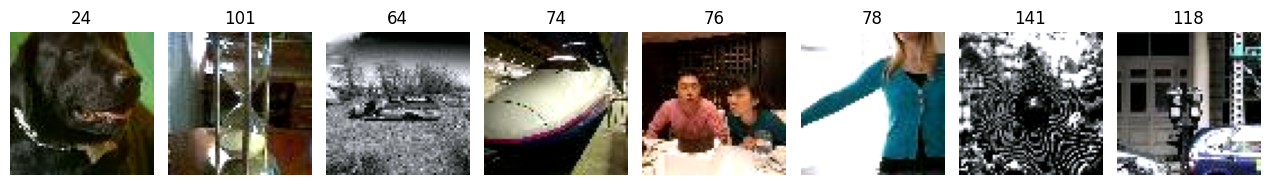

In [3]:
import matplotlib.pyplot as plt
import torch

def show_batch(images, labels, n=8):
    mean = torch.tensor((0.5071, 0.4867, 0.4408)).view(1,3,1,1)
    std  = torch.tensor((0.2675, 0.2565, 0.2761)).view(1,3,1,1)

    imgs = images[:n].cpu() * std + mean
    imgs = imgs.clamp(0, 1)

    fig, axes = plt.subplots(1, n, figsize=(1.6*n, 2))
    for i in range(n):
        axes[i].imshow(imgs[i].permute(1,2,0))
        axes[i].set_title(str(labels[i].item()))
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()


images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

---

# Training

In [ ]:
import timm
import torch.nn as nn

device = 'cuda'
model_resnet50 = timm.create_model(
    "resnet50",
    pretrained=False,
    num_classes=200).to(device)

model_resnet50.conv1 = nn.Conv2d(
    in_channels=3, 
    out_channels=64, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
    bias=False)

model_resnet50.maxpool = nn.MaxPool2d(
    kernel_size=3, 
    stride=2, 
    padding=1)

In [18]:
def count_trainable_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

n_params = count_trainable_parameters(model_resnet50)
print(f"Trainable parameters: {n_params:,}")

Trainable parameters: 23,910,152


In [ ]:
import random, numpy as np
from src.training.train_full_model import *

seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history, model_resnet50 = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_resnet50.pt",
    last_path="last_resnet.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=200,
    channels_last=True)


=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1406 | total_steps=35150 | warmup_steps=1757
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=200
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1406] loss 5.1554 | top1 2.46% | top3 5.86% | top5 8.98% | 731.2 img/s | lr 1.14e-04 | gnorm 2.777 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1406] loss 4.9753 | top1 3.71% | top3 8.87% | top5 12.98% | 791.5 img/s | lr 2.28e-04 | gnorm 2.950 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1200/1406] loss 4.8114 | top1 5.31% | top3 12.00% | top5 16.99% | 797.6 img/s | lr 3.41e-04 | gnorm 3.209 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1406/1406] loss 4.7399 | top1 6.09% | top3 13.42% | top5 18.71% | 804.6 img/s | lr 4.00e-04 | gnorm 3.325 | cli

---

In [21]:
evaluate_one_epoch(model=model_resnet50,dataloader=test_loader, device=device)

(2.4677578914642333, {'top1': 45.29, 'top3': 62.72, 'top5': 69.64})

In [25]:
import pickle

with open("ResNet50_TinyImagnet200.pkl", "wb") as f:
    pickle.dump(history, f)

---

## Food-101

In [ ]:
from src.data.load_food101 import *

train_loader, val_loader, test_loader = get_food101_hf_dataloaders(
     batch_size=64, num_workers=2, img_size=64, seed=7)

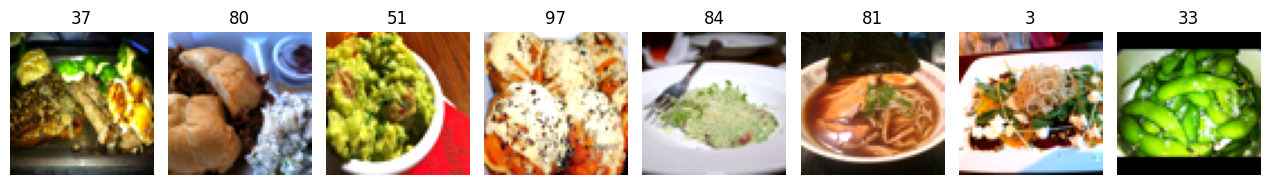

In [51]:
images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [52]:
device = 'cuda'
model_resnet50 = timm.create_model(
    "resnet50",
    pretrained=False,
    num_classes=101).to(device)

model_resnet50.conv1 = nn.Conv2d(
    in_channels=3, 
    out_channels=64, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
    bias=False)

model_resnet50.maxpool = nn.MaxPool2d(
    kernel_size=3, 
    stride=2, 
    padding=1)

In [53]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="PIL.TiffImagePlugin")


seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model_resnet50 = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_resnet50.pt",
    last_path="last_resnet.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=101,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=1183 | total_steps=29575 | warmup_steps=1478
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=101
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 400/1183] loss 4.5122 | top1 3.46% | top3 8.41% | top5 12.60% | 449.1 img/s | lr 1.35e-04 | gnorm 2.696 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1183] loss 4.3667 | top1 5.37% | top3 12.19% | top5 17.43% | 450.8 img/s | lr 2.71e-04 | gnorm 2.897 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1183/1183] loss 4.2580 | top1 6.99% | top3 15.23% | top5 21.11% | 451.1 img/s | lr 4.00e-04 | gnorm 3.163 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 4.2580 | top1 6.99% | top3 15.23% | top5 21.11% | lr 4.00e-04 | grad_norm 3.163 | clip 100.0% | amp_overflow

In [59]:
import pickle

with open("OutGrid_Food101.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## OxforsPets

In [ ]:
from src.data.load_oxfordpets import *

train_loader, val_loader, test_loader = get_oxford_pets37_dataloaders(
     batch_size=64, img_size=64, val_split=0.1, num_workers=4, seed=7)

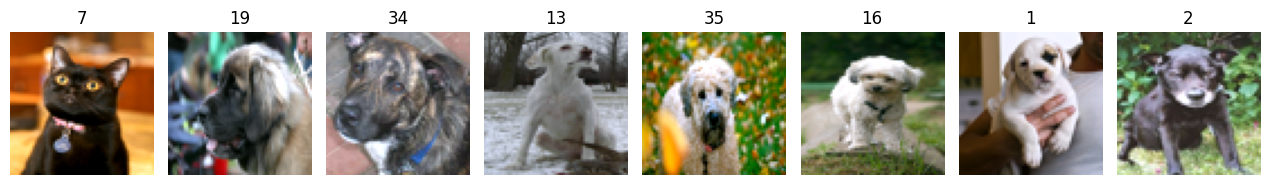

In [62]:
images, labels = next(iter(train_loader))
show_batch(images, labels, n=8)

In [63]:
device = 'cuda'
model_resnet50 = timm.create_model(
    "resnet50",
    pretrained=False,
    num_classes=37).to(device)

model_resnet50.conv1 = nn.Conv2d(
    in_channels=3, 
    out_channels=64, 
    kernel_size=3, 
    stride=1, 
    padding=1, 
    bias=False)

model_resnet50.maxpool = nn.MaxPool2d(
    kernel_size=3, 
    stride=2, 
    padding=1)

In [64]:
import random, numpy as np
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    module="PIL.TiffImagePlugin")



seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    epochs=25,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_resnet50.pt",
    last_path="best_resnet50.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=37,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=25 | steps/epoch=51 | total_steps=1275 | warmup_steps=63
batch_size=64 | input_shape=(64, 3, 64, 64) | num_classes=37
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/25 ===
[train step 51/51] loss 3.5715 | top1 5.67% | top3 13.94% | top5 20.80% | 468.3 img/s | lr 4.05e-04 | gnorm 2.753 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 3.5715 | top1 5.67% | top3 13.94% | top5 20.80% | lr 4.05e-04 | grad_norm 2.753 | clip 100.0% | amp_overflows 0 | nonfinite_loss 0 | scale 65536.0
[Train] mem_peak alloc 1.39 GiB | reserved 3.05 GiB
[Val]   loss 3.5380 | top1 5.71% | top3 15.22% | top5 24.18%
[Val]   mem_peak alloc 0.77 GiB | reserved 3.24 GiB
Best saved to best_resnet50.pt (val top1 5.71%)
Epoch time: 0.16 min

=== Epoch 2/25 ===
[train step 51/51] loss 3.3884 | top1 10.75% | top3 24.48%

In [65]:
evaluate_one_epoch(model=model_resnet50,dataloader=test_loader, device=device)

(3.124234880859113,
 {'top1': 17.198146633960206,
  'top3': 35.595530117198145,
  'top5': 46.715726355955304})

In [66]:
with open("ResNet_OxfordPets32.pkl", "wb") as f:
    pickle.dump(history1, f)

---

## SVHN

In [ ]:
from src.data.load_svhn import *

train_loader, val_loader, test_loader = get_svhn_dataloaders(
     batch_size=64, img_size=32, val_split=0.1, num_workers=2)

In [74]:
model_resnet50 = timm.create_model(
    "resnet50",
    pretrained=False,
    num_classes=10).to(device)

model_resnet50.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
model_resnet50.maxpool = nn.Identity()

In [77]:

seed = 77
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

random.seed(seed);
np.random.seed(seed)
torch.backends.cudnn.benchmark = True


history1, model = train_model(
    model=model_resnet50,
    train_loader=train_loader,
    epochs=10,
    val_loader=val_loader,
    device=device,

    lr=5e-4,
    weight_decay=0.05,

    autocast_dtype="fp16" if device == "cuda" else "fp32",
    use_amp=(device == "cuda"),
    grad_clip_norm=1.0,

    warmup_ratio=0.05,
    min_lr=1e-6,

    label_smoothing=0.1,

    print_every=400,
    save_path="best_resnet50.pt",
    last_path="best_resnet50.pt",
    resume_path=None,

    # Augmentations
    mix_prob=0.5,
    mixup_alpha=0.4,
    cutmix_alpha=0.4,

    num_classes=10,
    channels_last=True)

=== Run config ===
device=cuda | amp=True | autocast_dtype=fp16 | channels_last=True
epochs=10 | steps/epoch=1031 | total_steps=10310 | warmup_steps=515
batch_size=64 | input_shape=(64, 3, 32, 32) | num_classes=10
opt=AdamW | lr=0.0005 | wd=0.05 | grad_clip_norm=1.0
aug: mix_prob=0.5 | mixup_alpha=0.4 | cutmix_alpha=0.4 | label_smoothing=0.1

=== Epoch 1/10 ===
[train step 400/1031] loss 2.1786 | top1 22.29% | top3 47.75% | top5 66.44% | 862.3 img/s | lr 3.88e-04 | gnorm 2.832 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 800/1031] loss 1.6883 | top1 44.23% | top3 66.54% | top5 79.58% | 869.0 img/s | lr 4.99e-04 | gnorm 2.777 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[train step 1031/1031] loss 1.5128 | top1 51.64% | top3 72.01% | top5 83.18% | 876.3 img/s | lr 4.97e-04 | gnorm 2.639 | clip 100.0% | oflow 0 | nonfinite 0 | scale 65536.0
[Train] loss 1.5128 | top1 51.64% | top3 72.01% | top5 83.18% | lr 4.97e-04 | grad_norm 2.639 | clip 100.0% | amp_overf

In [78]:
evaluate_one_epoch(model=model_resnet50, dataloader=test_loader, device=device)

(0.17471026321936034,
 {'top1': 95.86662569145666,
  'top3': 98.95129071911494,
  'top5': 99.57744314689613})

In [79]:
with open("ResNet50_SVHNL.pkl", "wb") as f:
    pickle.dump(history1, f)